In [17]:
import harp
import utils
import matplotlib.pyplot as plt
import pandas as pd

h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)

h1_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/MotionLatencyTest/MotionLatencyTest/2024-11-14T15-43-03/HarpDataH1/'
h2_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/MotionLatencyTest/MotionLatencyTest/2024-11-14T15-43-03/HarpDataH2/'

In [18]:
# read harp streams
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
encoder = utils.load_harp(h2_reader.Encoder, h2_datafolder)
immediate_pulses = utils.load_harp(h2_reader.ImmediatePulses, h2_datafolder)

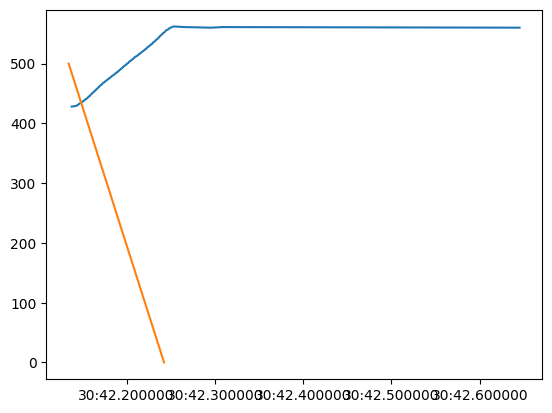

In [ ]:
start_time = encoder.index[0]

plt.figure()
plt.plot(encoder[start_time:start_time+pd.DateOffset(seconds=3.1)] - 10000)
plt.plot(immediate_pulses[start_time:start_time+pd.DateOffset(seconds=3.1)])